
✅ Dataset loaded successfully!

--- First 5 Rows ---
        u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101          17  
1  0.000606 -0.000785  24.538078    18.314955  19.850672  0.245417          17  
2  0.001290  0.000386  24.544693    18.326307  19.850657  0.176615          17  
3  0.000026  0.002046  24.554018    18.330833  19.850647  0.238303          17  
4 -0.064317  0.037184  24.565397    18.326662  19.850639  0.208197

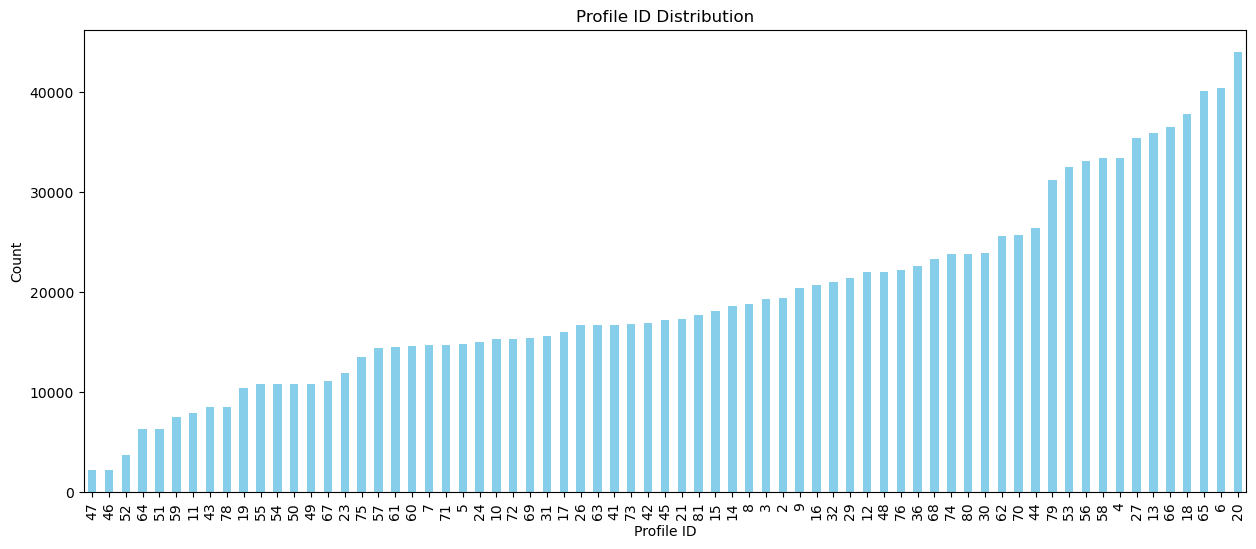


--- Null Values ---
u_q            0
coolant        0
u_d            0
motor_speed    0
i_d            0
i_q            0
pm             0
ambient        0
dtype: int64


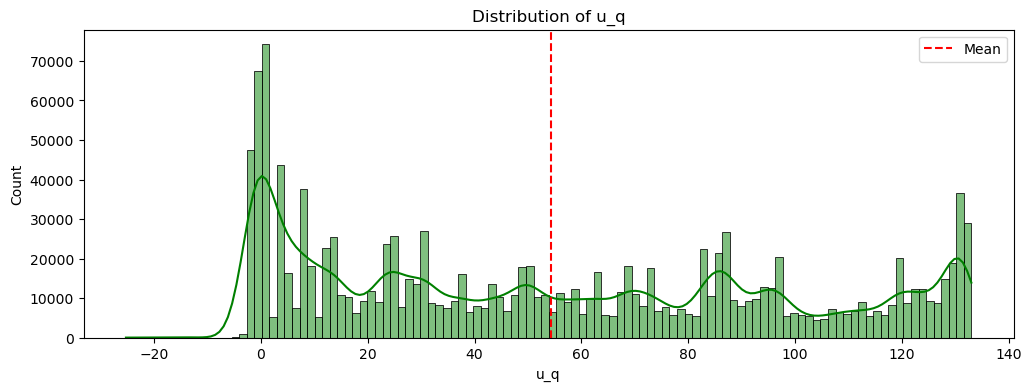

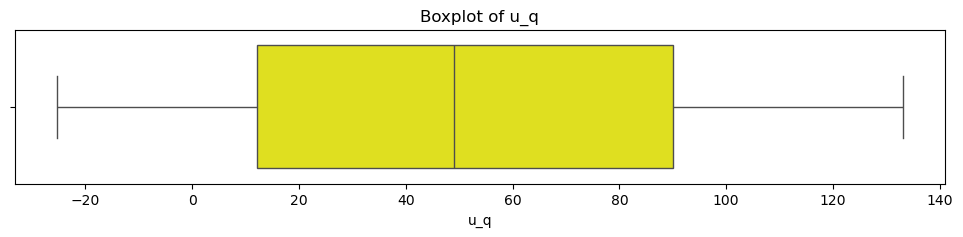

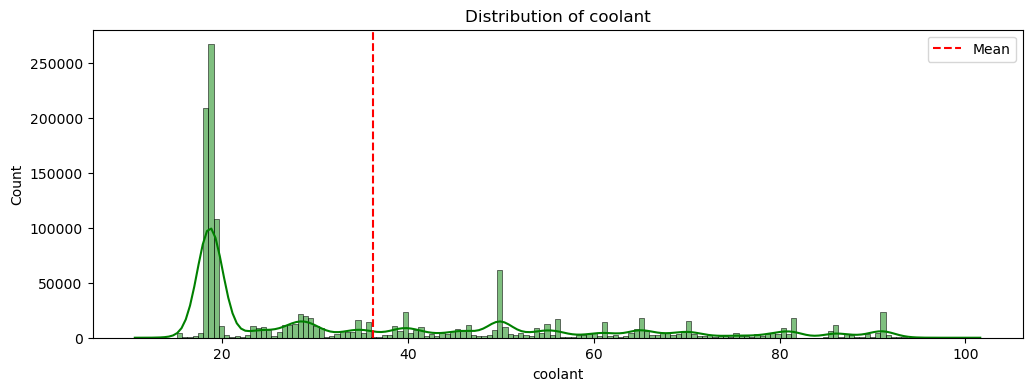

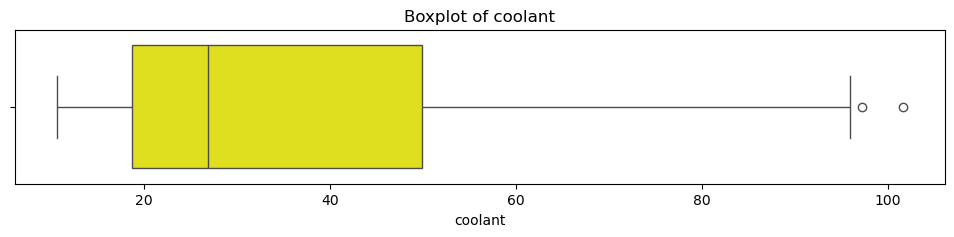

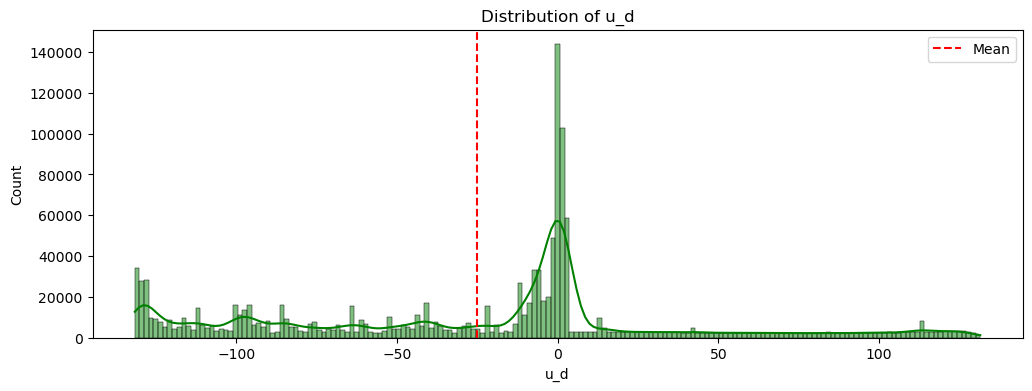

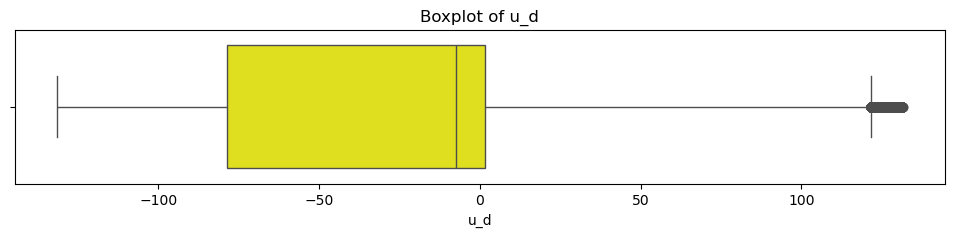

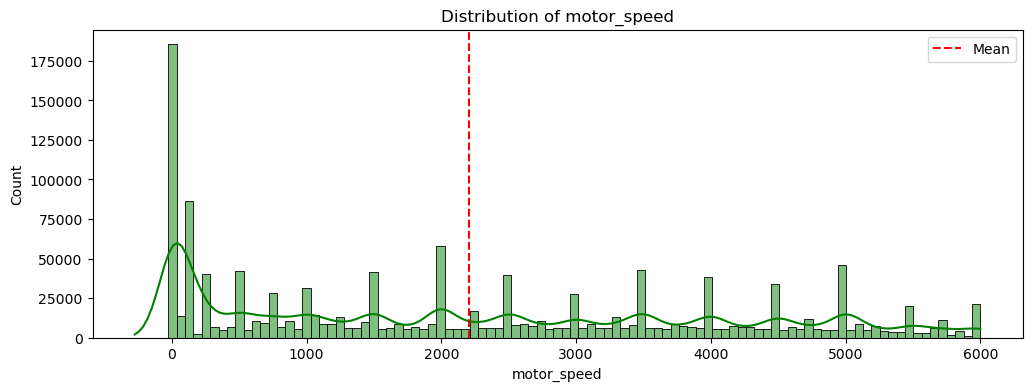

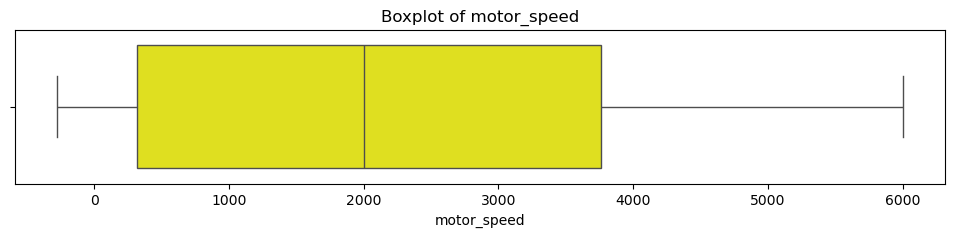

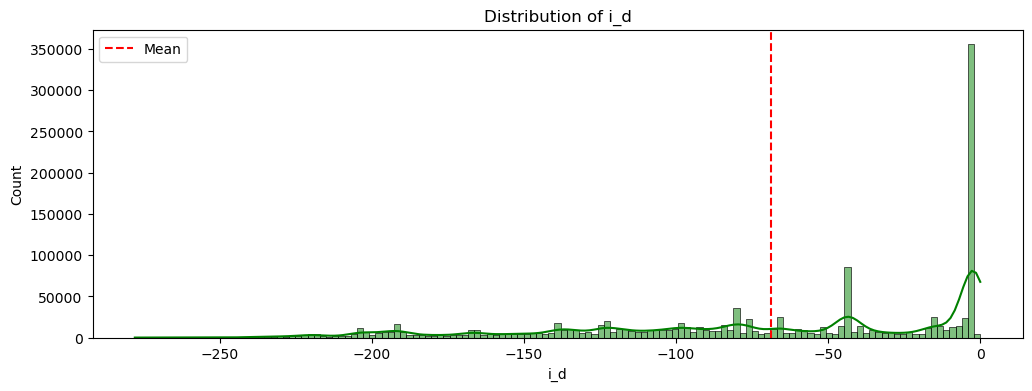

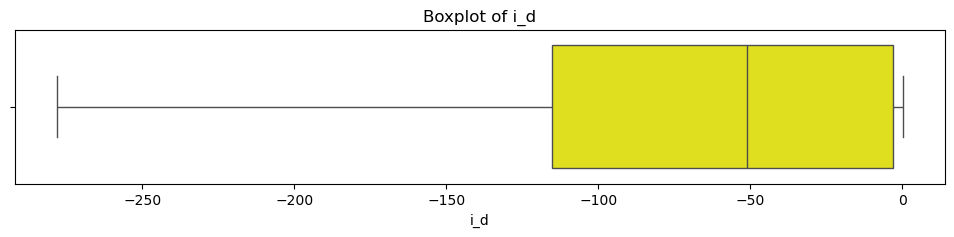

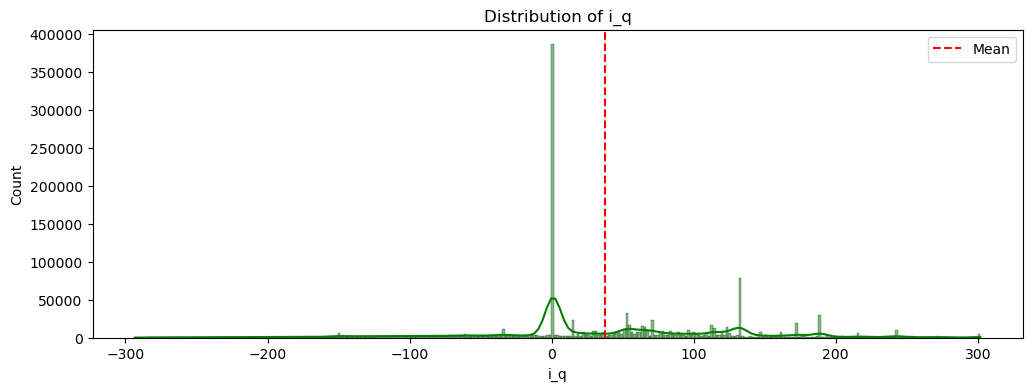

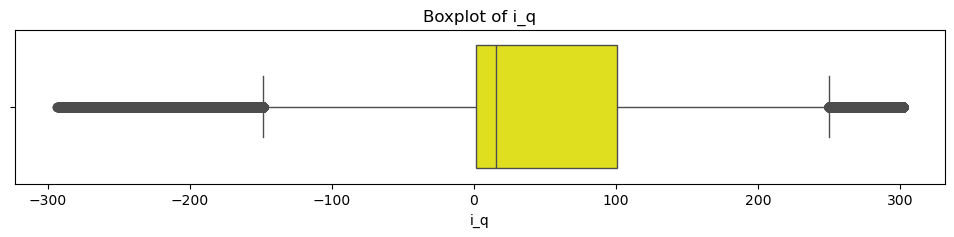

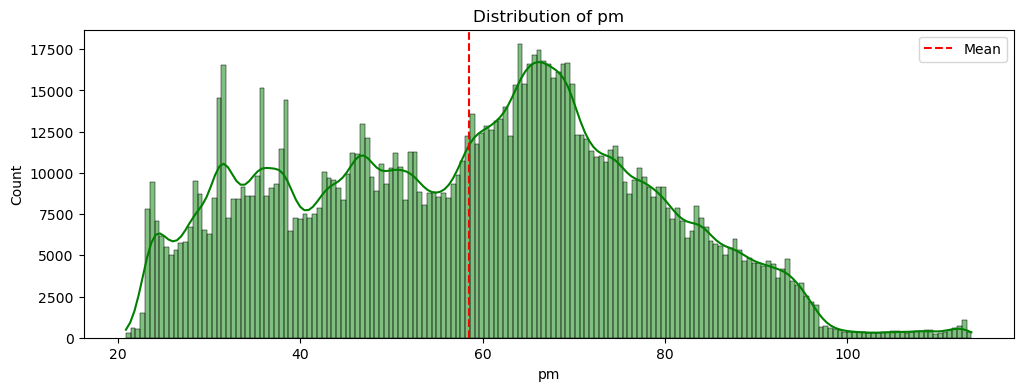

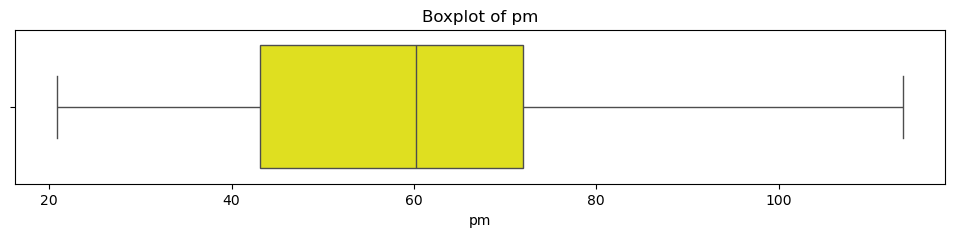

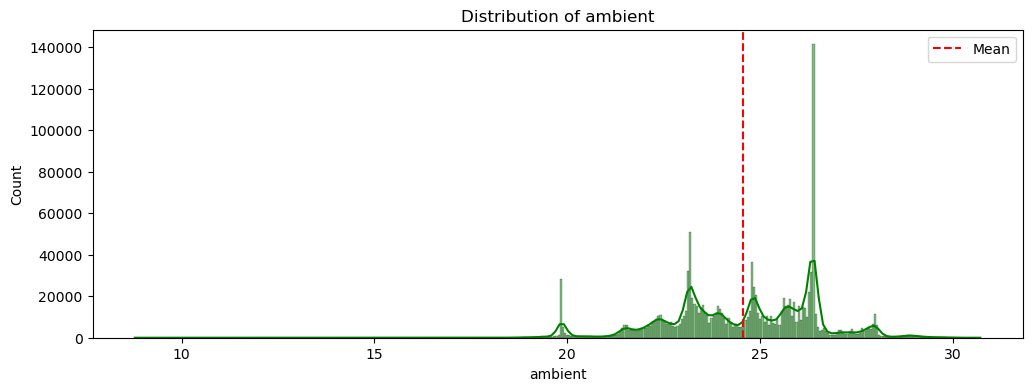

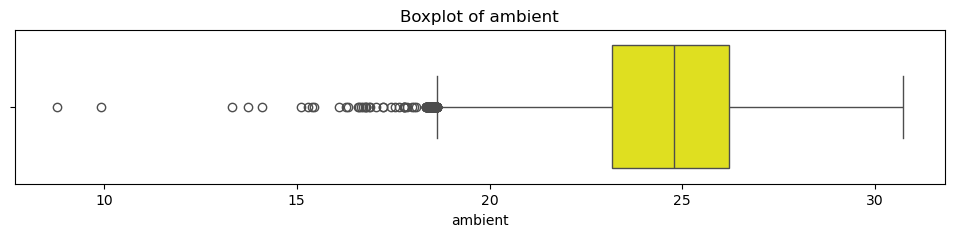

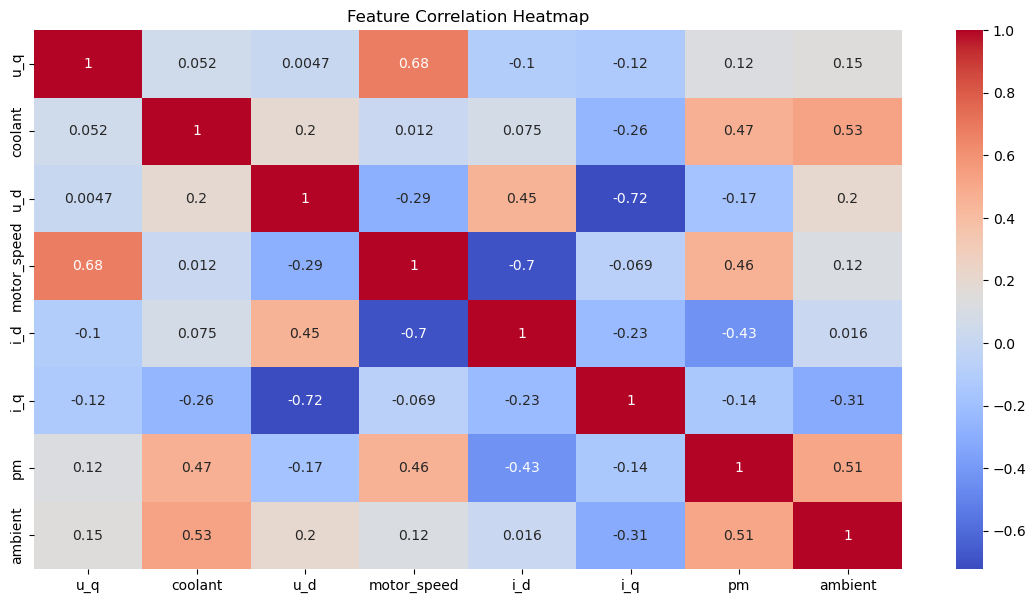


--- Model Performance ---
Decision Tree -> R²: 0.9823, MSE: 6.4061, MAE: 0.6964

✅ Best model (Decision Tree) saved successfully with R² = 0.9823


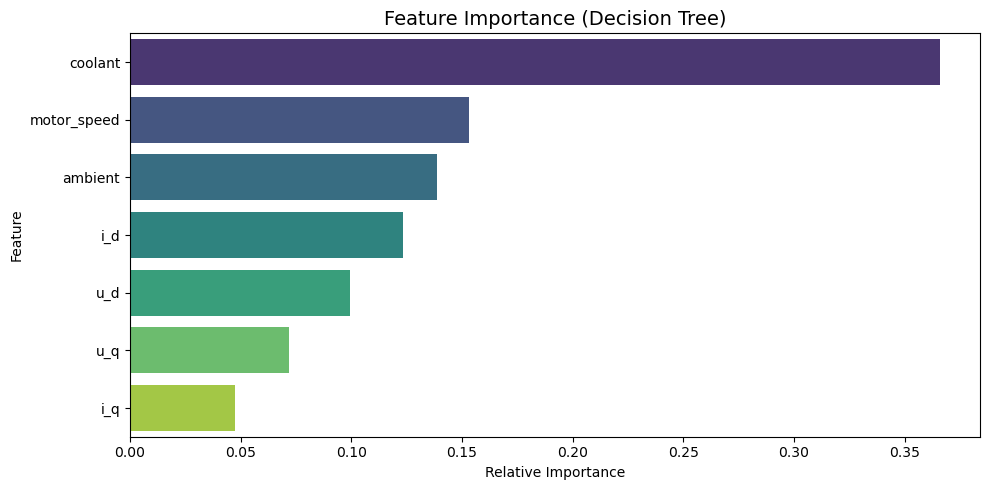

In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics
import joblib

# Ignore warnings
warnings.filterwarnings('ignore')

# Load dataset safely
try:
    df = pd.read_csv('D:/MyProjects/motorprediction/measures_v2.csv')
except FileNotFoundError:
    print("❌ Dataset not found. Please check file path!")
else:
    print("\n✅ Dataset loaded successfully!")
    print("\n--- First 5 Rows ---")
    print(df.head())

# Drop profile_id if it exists
if 'profile_id' in df.columns:
    plt.figure(figsize=(15,6))
    df['profile_id'].value_counts().sort_values().plot(kind='bar', color='skyblue')
    plt.title('Profile ID Distribution')
    plt.xlabel('Profile ID')
    plt.ylabel('Count')
    plt.show()
    df.drop(columns=['profile_id'], inplace=True)

# Drop unnecessary columns (only if they exist)
drop_cols = ['stator_yoke','stator_tooth','stator_winding','torque']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

# Check for null values
print("\n--- Null Values ---")
print(df.isnull().sum())

# Plot distributions and boxplots for numeric columns
for col in df.columns:
    plt.figure(figsize=(12,4))
    sns.histplot(df[col], kde=True, color='green')
    plt.axvline(df[col].mean(), color='red', linestyle='--', label='Mean')
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12,2))
    sns.boxplot(x=df[col], color='yellow')
    plt.title(f'Boxplot of {col}')
    plt.show()

# Correlation heatmap
plt.figure(figsize=(14,7))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Define features and target dynamically (exclude 'pm' which is the target)
features = [col for col in df.columns if col != 'pm']
X = df[features]
y = df['pm']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, 'transform.save')

# Convert back to DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=features)
X_test = pd.DataFrame(X_test_scaled, columns=features)

# Initialize models (only fast ones)
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    # Uncomment below if you want to try Random Forest too (slightly slower)
    # "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42)
}

print("\n--- Model Performance ---")
best_model = None
best_r2 = -float("inf")

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = metrics.r2_score(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    
    print(f"{name} -> R²: {r2:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}")
    
    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_model_name = name

# Save best model
joblib.dump(best_model, 'model.save')
print(f"\n✅ Best model ({best_model_name}) saved successfully with R² = {best_r2:.4f}")

# --- Feature Importance Visualization ---
if hasattr(best_model, "feature_importances_"):
    feature_importance = best_model.feature_importances_
    feature_df = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": feature_importance
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x="Importance", y="Feature", data=feature_df, palette="viridis")
    plt.title(f"Feature Importance ({best_model_name})", fontsize=14)
    plt.xlabel("Relative Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Feature importance not available for this model.")





In [3]:
import numpy as np
import joblib

# --- Load Model and Transformer for Prediction ---
def predict_rotor_temperature(input_data):
    """
    Predicts rotor temperature (pm) based on new input data.
    
    input_data: list or array in the order:
    ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
    
    Example:
        predict_rotor_temperature([20.5, 50.2, 0.12, 0.08, 1500, 0.01, 0.03])
    """
    # Load saved model and transformer
    model = joblib.load('model.save')
    scaler = joblib.load('transform.save')

    # Convert input data to 2D array
    input_array = np.array(input_data).reshape(1, -1)

    # Scale input
    input_scaled = scaler.transform(input_array)

    # Predict
    prediction = model.predict(input_scaled)
    return prediction[0]

# --- Example Prediction ---
sample_input = [20.5, 50.2, 0.12, 0.08, 1500, 0.01, 0.03]  # Replace with real values
predicted_temp = predict_rotor_temperature(sample_input)
print(f"Predicted Rotor Temperature (pm): {predicted_temp:.2f}")


Predicted Rotor Temperature (pm): 69.62
